# TempEst-NEXT Validation Suite

This Notebook provides a standard suite of model tests for TempEst-NEXT.  This serves two purposes:

1. Reproducibility of research.  This notebook is used to generate final manuscript figures relating to model performance. The notebook itself is provided with the published model and dataset, allowing exact reproducibility (and easy modification) of the analysis.
2. Efficient, consistent testing.  After modifying the model, running this notebook is a quick way to make sure everything still works and to assess performance impacts.

For validation, we use two pre-retrieved datasets as well as some automatic retrieval of new data.  The two pre-retrieved datasets are a "development" set of ~900 USGS gages (nominally 1,000; 900ish with overlapping data coverage) and a "test" set of 331 (nominal 400) USGS gages paired with daymet meteorology, 3DEP topography, NLCD land cover, etc.  The development set was used for model development and tuning, while the test set is reserved for final validation (i.e., here).  Test-set validations have been run during the development process, but are never used to directly inform model design.

The test suite also illustrates model runtime.

Some cells were used for initial data preparation, but do not need to be rerun.  These have been set to "raw" rather than Python, so simply running the entire Notebook will run all tests but nothing extraneous.

## Dependencies

To run the entire Notebook, requirements are:

- Python dependencies: TempEst-NEXT, matplotlib, and seaborn.  TempEst-NEXT is available (under that name) on the Python Package Index, so `pip install TempEst-NEXT`.
- A directory (specify location in `bp=` in the first cell) containing `DevData.csv`, `TestData.csv`, `DevDataHRRR3.csv`, and `TestDataHRRR3.csv`.  These should be provided with the notebook.  It should also contain a `results` subdirectory.
- In the same directory as the notebook:
    - An `ecoregions` directory, containing `NA_CEC_Eco_Level1.shp` (EPA Level I Ecoregions).
    - A `val_figures` directory

The preprocessing chunks have additional requirements, but are only used to generate the above data files and so don't need to be run.  They are set to `raw`, not `code`, so if the entire notebook is run they will not be executed.

Running the Notebook will reproduce all manuscript performance data and figures, except those relating to "true" forecasting (as opposed to reforecasting).  This is because performance evaluation for "true" forecasting requires separate steps to be run days apart and therefore can't be fully automated in a single run, though simply generating the forecast is automatic.

## Assessed Model Characteristics

The goal is to assess several model performance characteristics.  Forecasting is used for a handful of tests, but most analysis focuses on hindcasting for computational convenience.  It is assumed that any performance discrepancies in forecasting vs hindcasting would be apparent in the tests that cover both, and thus that not every analysis needs to test forecasting.

In this notebook, forecasting is primarily tested by using archived weather forecasts to predict what the forecast would have been for time periods where observations are available, which is necessary for automatic testing.  There is code to run a "real" forecast, but this cannot be automatically evaluated because observations are not available, so the user is left to go back and check once observations are available.

1. Calibrated model hindcasting and forecasting performance, using TempEst-NEWT like a typical single-watershed model
2. General ungaged hindcasting and forecasting performance
3. Ungaged-region hindcasting performance
4. Ungaged-elevation hindcasting performance
5. Ungaged-time-period hindcasting performance
6. Disturbance hindcasting performance?  TBD
7. Small-stream hindcasting performance?  TBD

## Tests

The following tests are used to assess the above performance characteristics.  Forecast tests cover just 2022, since HRRR retrieval is slow.

- Calibrated testing: train a model on the first 70% of observations for each stream, then evaluate performance for predicting the last 30%.  This uses the full dataset.
  - Use meteorology estimates (daymet) for training and testing: hindcast test.  Because the model architecture does not actually use "today's" weather (up through yesterday only), this is also a 24-hour forecast test.
  - Use weather forecast archives (HRRR, GFS/GEFS) for training and testing: forecast test.  Test forecast periods of 1, 2, 3 days.  Note forecast period is 1 day *past* the last day of the weather forecast, since NEWT does not depend on day-of weather.
  - Use meteorology estimates for training and forecasts for testing: evaluate the impact of heterogeneous datasets.  Use 2-day HRRR-forced forecast only.
- Gagewise cross-validation: partition development dataset gages into *k* equal sets.  Train a model on all partitions but one, and evaluate performance for predicting the excluded partition.  This tests general ungaged performance, not accounting for any potential impact of having used the same dataset for model tuning.  Hindcasting (met estimate) only.  This uses the development dataset to show whether model tuning introduced any performance discrepancies (compared to test set validation).
- Test set validation: train a model on the development set, and evaluate performance for predicting the test set.  This tests general ungaged performance for a fully-independent dataset.
  - Meteorology estimates (hindcast)
  - Weather forecast archives (forecast) for 1 (today), 2, and 3-day forecasts.  This has to be done with HRRR, since GFS doesn't have as readily-available long-term archives.
    - Trained on estimates/test on forecasts (forecast with heterogeneous data).
- Extrapolation hindcasting tests: partition the combined development and testing sets along some characteristic of interest, and use a model trained on one group to predict the other group.  This tests the ability of TempEst-NEXT to extrapolate in terms of specific characteristics.  All hindcasting.
  - Regional: partition the CONUS into contiguous regions and run leave-one-out cross-validation over the regions.
  - Elevation: train a model on the lower elevations and predict higher elevations.  Partial dependency plots and previous research suggest there is a major shift in watershed dynamics around 2300 m, and it is difficult to extrapolate past that barrier.
  - Time (walk-forward validation): train a model up to a given year, then predict the next year.  This tests whether the model can extrapolate forward in time.
- Regime-shift hindcasting: identify a set of watersheds for which the observed thermal regime has shifted significantly.  Train the model on everything else, then try to predict the disturbed watersheds and see how the model performs.  This assesses whether TempEst-NEXT is capable of capturing regime shifts.
- Small-stream hindcasting: if possible, use the model to predict temperatures at very small (e.g., first-order headwaters, centimeters to a few meters wide) streams where some observations are available, just to see if it works there.

# Data Preparation

In [1]:
import NEXT
import NEWT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import dataretrieval.nwis as nwis
import geopandas as gpd
import matplotlib.animation as anim
import shapely
import scipy
warnings.catch_warnings(action="ignore")
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


There are some major outliers that are either erroneous (negative temperatures) or wildly unrepresentative (hot springs) that we remove to produce realistic performance estimates.

In [2]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).drop(columns=["swe", "tmin"]).dropna()
dev_data = dev_data[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]
test_data = pd.read_csv(bp + "TestDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).dropna()
test_data["day"] = test_data["date"].dt.day_of_year
all_data = pd.concat([dev_data, test_data]).drop(columns=["asp_north", "asp_east", "id_type", "unknown", "elev_std", "frozen", "cold_prcp"])
test_data_hrrr = pd.read_csv(bp + "TestDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(test_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")
dev_data_hrrr = pd.read_csv(bp + "DevDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(dev_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")

### Forecast Archive Retrieval (does not need to be run)

A one-month run takes 0.02 hours, so 72 months should be about 1.5 hours, for a total of ~500 core-hours for the test set.  Needs to be run distributed.

### Data Preprocessing (does not need to be run)

# Calibrated Tests

Full dataset.

In [3]:
def cut_dev(gid, data, start=None):
    idd = data[data["id"] == gid]
    if idd["temperature"].mean() > 35 or idd["temperature"].mean() < 0:
        return (None, None)  # bad data or major outlier
    if start is None:
        cut = round(len(idd) * 0.7)
        if cut >= 365:
            return (idd.iloc[cut:], idd["date"].iloc[cut+1])
        else:
            return (None, None)  # dataset too small
    else:
        return idd[idd["date"] >= start]

def cal_val(gid, data, test_data = None, cal_fn = cut_dev, val_fn = cut_dev):
    (train, cutoff) = cal_fn(gid, data)
    if test_data is None:
        test_data = data
    # try:
    if cutoff is not None:
        test = cal_fn(gid, data, cutoff)
        model = NEWT.Watershed.from_data(train)
        if model is not None:
            return model.run_series(test)
    # except Exception as e:
    #     warnings.warn(str(e))

## Hindcast

In my last test, 919 watersheds took 26 minutes to train and predict, for about 2 seconds per watershed.

With GAM-sensitivity, 1225 watersheds took 42 minutes to train and predict, still at ~2 seconds each.

With full-series runs and GAM-sensitivity, 1225 watersheds took 10 minutes to train and predict, for ~0.5 seconds each.

In [4]:
file = bp + "results/calibrated_hindcast_anomgam.csv"
rerun = True
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    # with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x, all_data) for x in all_data["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

Trained and ran 1225 watershed models in 9.6 minutes.


Overall performance summary below.  Note that stationarity, in particular, does absurdly well as a comparison point (same temperature today as yesterday).  As far as I'm aware, this comparison has not been run for most previous models.  It would be interesting to see how much of a lag is required for NEWT to outperform stationarity.  This does suggest that, if you have observations, "same as yesterday" is probably a better bet than most non-data-assimilating models.

Interestingly, when a massive outlier that was predicting anomalies in the thousands of degrees is removed, global performance is very similar to gagewise performance.  Note that huge anomaly sensitivity isn't representative of any real use case, since in a calibrated model that would be corrected for and the (smoothed) coefficient estimation model won't predict such high sensitivity.  (If it did happen, it would be fairly obvious that ~3000 C is not a reasonable estimate.)

Using GAM-anomaly reduced median and global RMSE by about 0.1 C to 1.4 C (for both).  Anomaly NSE increased to 0.61 (0.92 globally), median R2 to 0.95, and global R2 to 0.97.  Overall NSE increased to 0.95 and 0.97.

In [5]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

                R2         RMSE          NSE  StationaryNSE  ClimatologyNSE  \
count  1225.000000  1225.000000  1225.000000    1225.000000     1225.000000   
mean      0.937239     1.399260     0.937216       0.976792        0.952454   
std       0.067876     0.418123     0.067980       0.017578        0.049009   
min       0.373559     0.105841     0.368970       0.816626        0.287647   
25%       0.933140     1.159236     0.933120       0.969542        0.937219   
50%       0.952756     1.385955     0.952756       0.980354        0.959158   
75%       0.967694     1.607111     0.967692       0.988710        0.978736   
max       0.992099     6.878888     0.992096       0.999010        1.000000   

        AnomalyNSE        Pbias         Bias      MaxMiss  
count  1089.000000  1225.000000  1225.000000  1225.000000  
mean      0.558623     0.000476     0.000101     1.232096  
std       0.199053     0.029506     0.003798     0.756507  
min      -0.346025    -0.231682    -0.025038    

In [6]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.967168,1.413601,0.967168,0.983529,0.599304,0.922899,0.000155,0.000021,1.457304


## Forecast

### Homogeneous Forecast
Trained and tested with HRRR.  Note this limits the data coverage (~2018-22).

### Heterogeneous Forecast
Trained with Daymet, tested with HRRR.

# Gagewise Cross-Validation

Runtime: 1.9 hours for 930 sites and ~3M observations.  That makes >1.5 years/second, assuming most of the time is prediction, and a total of 7.5 seconds per site.

With no modification engines, it is 0.43 hours, making 1.7 seconds/site and >5 years/second.

With full-series runs and GAM-sensitivity, training still takes a few minutes, but prediction is almost instantaneous.  It still takes 0.4 hours total, suggesting that runtime is dominated by model training.  Oddly, performance is not improved by the GAM-sensitivity.

In [7]:
# Modbuilder: data -> (ws -> prediction)
logfile = bp + "results/kfold_log.txt"
def make_modbuilder(use_clim, lookback):
    def next_modbuilder(data):
        nx = NEXT.NEXT.from_data(data)
        def prd(x):
            print("|", end="")
            try:
                # return nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt().coefs_to_df()
                return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
                # mod = nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt()
                # mod.dynamic_engine = None
                # return mod.run_series(x)
            except KeyboardInterrupt as e:
                raise e
            except Exception as e:
                print("Error", end="")
                with open(logfile, "a") as lf:
                    lf.write(f"Error in gage {x["id"].iloc[0]} for use_clim={use_clim} and lookback={lookback}: {e}\n")
                return None
        return prd
    return next_modbuilder

In [8]:
clim=False
lookback = 10
timing = bp + "results/kfold_times.txt"
out = bp + "results/kfold_pca_agam.csv"
rerun=True
with warnings.catch_warnings(action="ignore"):
    start = time.time()
    kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=out, redo=rerun)
    if rerun:
        print(f"\nLookback: {lookback} : {(time.time() - start) / 3600: .2f} hours for {len(dev_data["id"].unique())} sites with {len(dev_data)} observations")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Lookback: 10 :  0.38 hours for 928 sites with 2987900 observations


In [9]:
with warnings.catch_warnings(action="ignore"):
    perf = kfr.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,928.000000,928.000000,928.0,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,40.024700,-93.773787,0.0,0.900635,2.462355,0.389756,0.976446,0.914499,0.425439,3.342683,0.241795,2.788877
std,4.522685,17.162228,0.0,0.122705,1.261039,5.945442,0.017760,0.066952,0.240702,16.249757,1.701159,1.959434
min,26.975000,-124.392987,0.0,0.004975,0.961918,-170.634561,0.858323,0.175511,-1.521640,-72.901114,-21.935335,0.052315
25%,37.730899,-109.882554,0.0,0.897333,1.823410,0.785975,0.969363,0.900950,0.305367,-4.175425,-0.570312,1.279140
50%,40.132276,-86.485407,0.0,0.936383,2.184216,0.887757,0.980235,0.928521,0.485819,1.474962,0.178289,2.429349
75%,42.986410,-79.563692,0.0,0.954959,2.722319,0.929716,0.988397,0.949401,0.602167,7.840358,1.008563,3.799227
max,48.998814,-67.803889,0.0,0.982442,22.599865,0.981724,0.999005,0.988499,0.767662,194.911884,10.380650,21.917748


## Plots

In [10]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

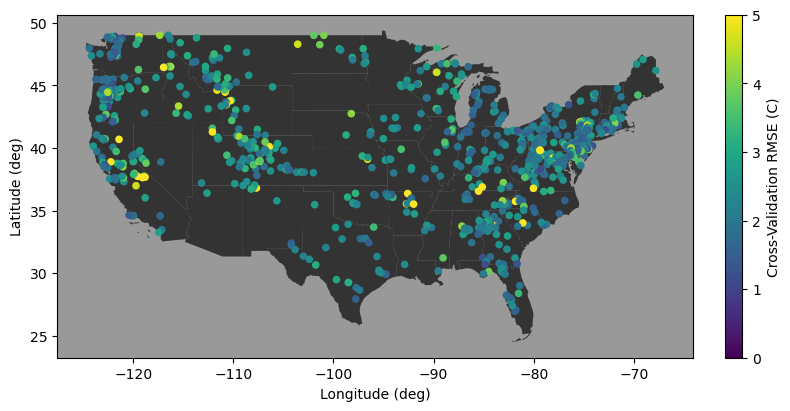

In [11]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="RMSE", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation RMSE (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_rmse.png", dpi=1000)

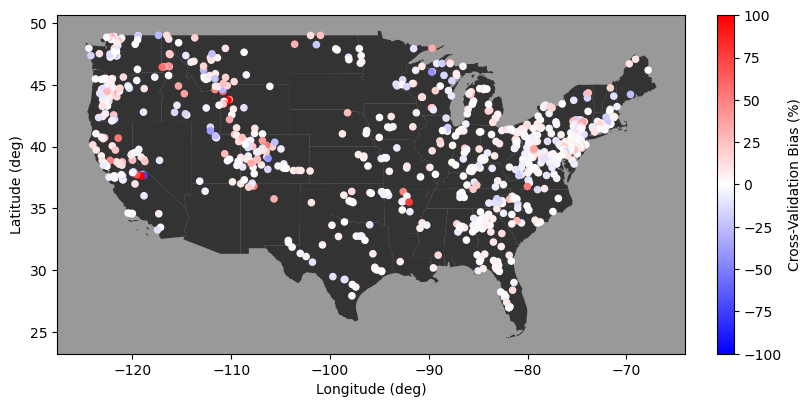

In [12]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="Pbias", ax=ax, colormap="bwr", vmin=-100, vmax=100)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation Bias (%)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_bias.png", dpi=1000)

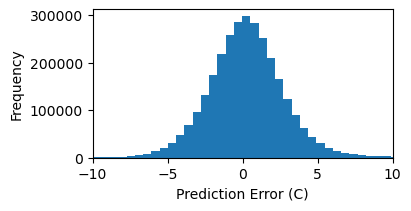

In [13]:
fig = plt.figure(figsize=(4, 2), layout="compressed")
ax = plt.axes()
kfr["error"] = kfr["temp.mod"] - kfr["temperature"]
kfr["error"].plot.hist(bins=100, ax=ax)
ax.set_xlim(-10, 10)
ax.set_xlabel("Prediction Error (C)")
plt.savefig("val_figures/ErrorHist_xv.png", dpi=1000)

In [14]:
ecos = gpd.read_file("ecoregions/NA_CEC_Eco_Level1.shp").to_crs(4326)

In [15]:
def get_name(df):
    if len(df) > 0:
        return df.iloc[0]["NA_L1NAME"].title()
    else:
        return "NA"
perf_pts = gpd.GeoSeries([shapely.Point(x.lon, x.lat) for x in perf.itertuples()])
pt_ecos = pd.Series([get_name(ecos[ecos.contains(x)]) for x in perf_pts])

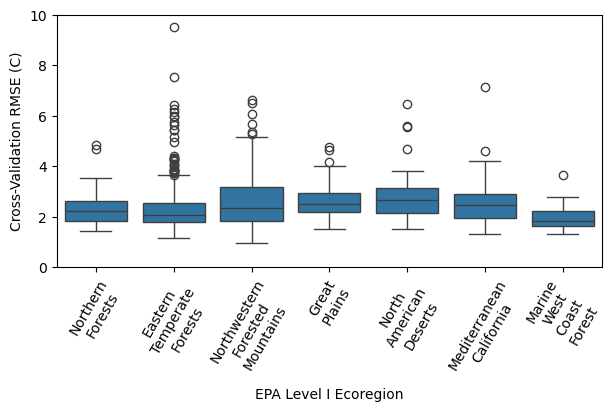

In [16]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf[perf["ecoregion"] != "NA"], y="RMSE", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(0, 10)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation RMSE (C)")
plt.savefig("val_figures/EcoregionRMSEBox.png", dpi=1000)

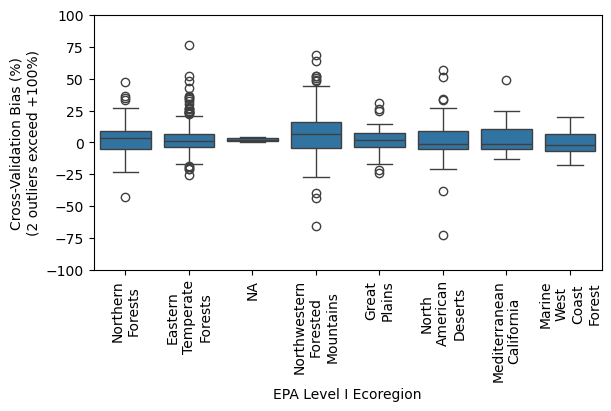

In [17]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf, y="Pbias", x="ecoregion", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(-100, 100)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation Bias (%)\n(2 outliers exceed +100%)")
plt.savefig("val_figures/EcoregionBiasBox.png", dpi=1000)

# Test Set Validation

In [8]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data)
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 130 seconds to train


In [11]:
# model.to_pickle("coefs.pickle")

## Hindcast

This (full timeseries for 750k rows/331 watersheds) took 22 minutes, 1300 seconds.  As before, that's about 1.5 years per second.  The next run took 1200 seconds.

With single-pass and GAM-sensitivity, it took 24 seconds, or 86 years per second.

In [19]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [20]:
ppath = bp + "results/TestSet_hindcast_pca.csv"
rerun = True
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 27 seconds to predict


In [21]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,320.000000,320.000000,320.0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,39.902969,-95.030326,0.0,0.891935,2.601967,-0.284901,0.977027,0.913633,0.337632,1.484876,0.038793,2.721210
std,4.643460,17.260681,0.0,0.135488,2.910468,11.521710,0.019028,0.076485,1.156313,19.212956,3.083472,2.412714
min,28.332787,-124.357089,0.0,0.052478,1.302259,-194.732574,0.824755,0.339466,-19.258914,-180.356841,-39.596609,0.301789
25%,36.555978,-111.425710,0.0,0.888064,1.810788,0.778898,0.970903,0.898901,0.289171,-4.356051,-0.613157,1.198693
50%,40.175895,-87.479876,0.0,0.935595,2.209298,0.893665,0.980564,0.931081,0.489467,0.709293,0.095073,2.075884
75%,43.327292,-81.167361,0.0,0.954961,2.730184,0.928455,0.989143,0.949809,0.599050,7.750873,0.990884,3.575076
max,48.984601,-67.935278,0.0,0.982252,41.769592,0.976768,0.999024,0.996135,0.771518,105.164948,6.190628,25.286023


## Reforecast (heterogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 2-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict tomorrow).

For comparison purposes here, the median R2 of pure climatology (i.e., fitted seasonality) is 0.90.  Stationarity probably does better than NEXT, but stationarity isn't actually available in an ungaged context - though, of course, neither is climatology!

RMSE did increase a fair bit, to 2.9 C.  That seems to be driven by an increase in bias (to 8%/1.0 C), which probably has to do with the heterogeneous training data.  (Next up: pull HRRR for the full dataset and do a homogeneous run.)  Still, the R2 is better than climatology at 0.92.  (See below: it's the heterogeneity.)  The PCA, GAM-sensitivity version did a bit better than the original here.

In [22]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [23]:
ppath = bp + "results/TestSet_reforecast_pca.csv"
rerun = True
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 25 seconds to predict


In [24]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.876114,3.329097,-0.762987,0.977262,0.929838,0.157205,9.702745,1.032909,3.001118
std,4.677083,17.366814,0.0,0.140837,2.982240,13.570102,0.020124,0.071528,1.566625,24.181480,3.481173,2.630682
min,28.332787,-124.357089,0.0,0.057406,1.179167,-223.167601,0.824468,0.335259,-21.795661,-174.569434,-37.929040,0.160290
25%,36.610189,-111.746329,0.0,0.871270,2.272492,0.616805,0.971265,0.920568,0.215189,0.667105,0.101508,1.261483
50%,40.036652,-88.156111,0.0,0.919504,2.863323,0.792151,0.980738,0.945719,0.360439,8.229291,1.040241,2.531286
75%,43.349958,-81.273662,0.0,0.945228,3.599670,0.889407,0.989726,0.961223,0.499755,17.758027,2.374565,4.002849
max,48.984601,-67.935278,0.0,0.983171,39.927930,0.973647,0.999039,1.000000,0.753439,203.419748,12.862661,25.007912


## Reforecast (homogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 3-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict the day after tomorrow).  It goes a day past the HRRR coverage because the day-of weather isn't actually used.

For comparison purposes here, the median R2 of pure climatology (i.e., fitted seasonality) is 0.90.  Stationarity probably does better than NEXT, but stationarity isn't actually available in an ungaged context - though, of course, neither is climatology!

It does better with a homogeneous reforecast; RMSE decreases to 2.4 C.  R2 doesn't change.

In [25]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data_hrrr.dropna())
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 82 seconds to train


In [26]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [27]:
ppath = bp + "results/TestSet_reforecast_homog_pca.csv"
rerun = True
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 23 seconds to predict


In [28]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.879496,2.831106,-0.591534,0.977262,0.929838,0.245989,0.564824,-0.126074,3.273309
std,4.677083,17.366814,0.0,0.141324,2.226816,15.553042,0.020124,0.071528,0.637658,18.277553,2.739255,2.791106
min,28.332787,-124.357089,0.0,0.006957,1.230511,-266.003473,0.824468,0.335259,-7.394214,-116.802279,-25.377858,0.190550
25%,36.610189,-111.746329,0.0,0.876786,2.015918,0.751898,0.971265,0.920568,0.211267,-4.902516,-0.682510,1.516664
50%,40.036652,-88.156111,0.0,0.920091,2.423915,0.866306,0.980738,0.945719,0.337701,1.013856,0.116897,2.671078
75%,43.349958,-81.273662,0.0,0.945276,2.883060,0.913507,0.989726,0.961223,0.430812,7.586349,0.943951,4.219844
max,48.984601,-67.935278,0.0,0.982071,26.132810,0.970286,0.999039,1.000000,0.684855,77.764572,8.379258,21.120805


# Extrapolation Tests

## Regional

For regional extrapolation, we split the CONUS into 16 grid cells (four-by-four), of which 15 actually contain gages and 14 have more than 1 gage.  Across those 14, we run a leave-one-out cross-validation, training a model on the other 13 and predicting all gages in the left-out grid cell.  This tests the ability of the model to make predictions for contiguous regions with no gages, meaning that it has no training data from nearby sites and has to go off its knowledge of general trends.

The cell 0x0 (southwesternmost) only has one gage in it, so results from that one should probably be ignored, but we'll include it.  The next fewest gages is 9, in Maine (3x3).  Some cells are, of course, considerably sparser than others, and gage count additionally varies with the size of cells on the US borders, as in the case of both 0x0 and 3x3.

<Axes: xlabel='lon', ylabel='lat'>

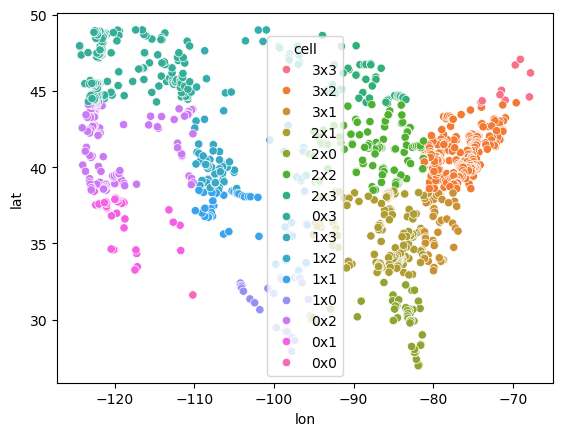

In [29]:
N = 4
latmin = all_data["lat"].min()
latmax = all_data["lat"].max() + 1
lonmin = all_data["lon"].min()
lonmax = all_data["lon"].max() + 1
latstep = (latmax - latmin)/N
lonstep = (lonmax - lonmin)/N

all_data["lat_cell"] = ((all_data["lat"] - latmin) / latstep).astype("int")
all_data["lon_cell"] = ((all_data["lon"] - lonmin) / lonstep).astype("int")
all_data["cell"] = all_data["lon_cell"].astype("str") + "x" + all_data["lat_cell"].astype("str")
sns.scatterplot(all_data.groupby("id")[["lat", "lon", "cell"]].first(), x="lon", y="lat", hue="cell")

In [30]:
def modbuilder(data):
    nx = NEXT.NEXT.from_data(data)
    print("New region", end="")
    def prd(x):
        print("|", end="")
        try:
            return nx.run(x, reset=True)
        except KeyboardInterrupt as e:
            raise e
        except:
            return None
    return prd
with warnings.catch_warnings(action="ignore"):
    spatxv = NEWT.analysis.kfold(all_data, modbuilder, by='cell', k=1, output = bp + "results/SpatialXV_PCA.csv", redo=True)

New region||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||New region|||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [31]:
with warnings.catch_warnings(action="ignore"):
    spatperf = spatxv.groupby(["id", "cell"]).apply(NEWT.analysis.perf_summary)

Globally, there is a modest penalty, with RMSE increasing to 2.4 C.  R2, however, is not affected.

In [32]:
spatperf.describe()

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000
mean,0.896763,2.718590,0.142445,0.976595,0.914277,0.406429,6.264538,0.515157,2.870362
std,0.124105,1.302623,7.909090,0.018088,0.069490,0.326013,18.842847,1.922063,2.073038
min,0.003458,1.129034,-256.977320,0.824755,0.175511,-5.622693,-77.329334,-19.431778,0.211304
25%,0.892186,1.967253,0.706238,0.969744,0.900802,0.307205,-3.732749,-0.517013,1.313326
50%,0.933711,2.375757,0.873015,0.980302,0.928942,0.478390,3.504094,0.468727,2.448940
75%,0.953870,3.062145,0.925041,0.988712,0.949556,0.588621,11.101050,1.483877,3.912780
max,0.982264,20.101017,0.979306,0.999024,0.996135,0.766253,149.583259,7.800187,20.285129


In [33]:
spatperf.groupby("cell")["RMSE"].median()

cell
0x0    4.214946
0x1    3.322474
0x2    2.699880
0x3    3.301856
1x0    2.518915
1x1    2.536498
1x2    2.514392
1x3    3.271438
2x0    2.694366
2x1    2.281652
2x2    2.185082
2x3    2.574463
3x1    2.167596
3x2    2.047960
3x3    2.959874
Name: RMSE, dtype: float64

Performance does vary somewhat with region, but all have a median RMSE of 2.0-3.3 C except the one-gage one.

(0.0, 10.0)

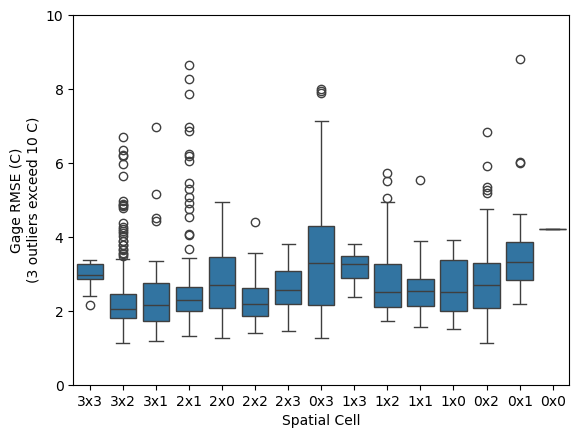

In [34]:
ax = sns.boxplot(spatperf, x="cell", y="RMSE")
ax.set_xlabel("Spatial Cell")
ax.set_ylabel("Gage RMSE (C)\n(3 outliers exceed 10 C)")
ax.set_ylim(0, 10)

## Elevation

For elevation extrapolation, we train on the lower 95% and test on the upper 5%.  We also just plot errors by elevation.

### Non-Extrapolating

To look at bias, remove the `.abs()`.  There is no trend in bias and a modest trend in absolute error (about 2 -> 2.6 C in the combined cross-validation and test sets).  However, this seems to be because median errors are very high in the 2000-2500 m range; otherwise, there's no obvious trend.  With that group removed, the trend is present but weaker.

In [35]:
preds = pd.read_csv(bp + "results/TestSet_hindcast_pca.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + "results/kfold_pca_agam.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "elev_min", "date", "temp.mod", "temperature"]
preds = pd.concat([preds[cols], kfr[cols]])

In [36]:
preds["error"] = (preds["temp.mod"] - preds["temperature"]).abs()
elev_perf = preds.groupby("id")[["elev_min", "error"]].mean()

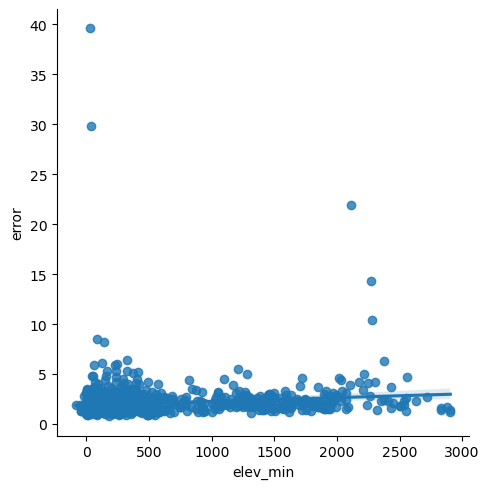

In [37]:
sns.lmplot(elev_perf, x="elev_min", y="error")

In [38]:
elev_perf.assign(elev_bucket = lambda x: x["elev_min"] // 500).groupby("elev_bucket").median()

,elev_min,error
elev_bucket,,
-1.0,-0.904104,1.551307
0.0,183.398407,1.707104
1.0,622.275818,1.723893
2.0,1272.117493,2.104816
3.0,1747.874878,1.935522
4.0,2225.939331,3.181459
5.0,2596.154053,1.772929


### Extrapolating

In [39]:
all_data["elev_min"].quantile(0.95)

1804.63671875

In [43]:
train = all_data[all_data["elev_min"] < 1800]
test = all_data[all_data["elev_min"] >= 1800].dropna()

In [44]:
len(test["id"].unique())

73

In [46]:
def predict(model, ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except ValueError:
        return None

with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(train)
    prd = test.groupby("id").apply(lambda x: predict(model, x), include_groups=False).reset_index().drop(columns="level_1")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Extrapolating to high elevation increases median RMSE to 2.8 C (+0.6), which is a much lower penalty than TempEst 2 (+1.1).  Also, bias is much less, but R2 is penalized more.

In [47]:
with warnings.catch_warnings(action="ignore"):
    perf = prd.groupby(["id", "lat", "lon", "elev_min"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index().drop(columns="level_4")
perf.describe()

,lat,lon,elev_min,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,40.810145,-109.973413,2150.934957,0.806565,3.683828,-1.042839,0.965294,0.888302,0.087420,-10.699804,-1.370697,5.325182
std,2.647192,3.939242,299.971934,0.144169,2.921948,8.473863,0.021397,0.125613,0.226543,31.980208,3.796488,3.756643
min,35.777114,-120.237979,1801.255615,0.035741,1.594946,-67.144856,0.911176,0.175511,-0.634872,-76.863152,-20.387433,0.587429
25%,38.903669,-110.969782,1905.190430,0.772900,2.374726,0.120963,0.952420,0.878278,-0.085617,-25.603454,-2.498429,2.714344
50%,40.202484,-109.449023,2038.598145,0.845648,2.807798,0.637712,0.971936,0.913860,0.132254,-4.454483,-0.521851,4.769910
75%,43.479561,-107.154035,2363.684204,0.883053,3.822201,0.777857,0.982283,0.942313,0.247325,9.057808,0.552605,6.965436
max,45.617967,-105.584139,2905.092529,0.952265,20.995228,0.899251,0.994626,0.985451,0.501329,67.875811,3.614942,22.288225


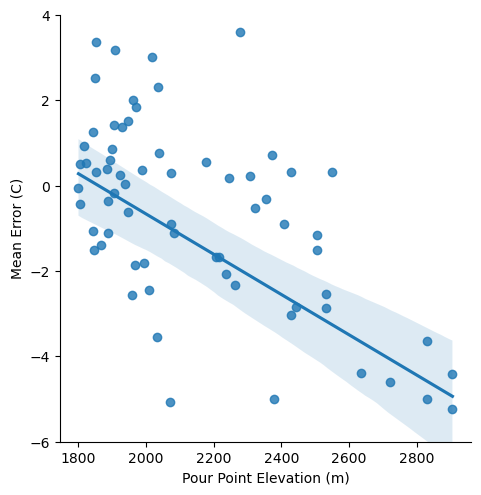

In [50]:
ax = sns.lmplot(perf, x="elev_min", y="Bias")
ax.set_axis_labels("Pour Point Elevation (m)", "Mean Error (C)")
ax.set(ylim=(-6, 4))

## Walk-Forward

For walk-forward validation, we train a model on all sites up to a given year, then predict the next five year.  This is done for all prediction years from 2010-2022, allowing ten years of initial training data.  We predict five years at a time to provide sufficient coefficient estimation data, since it's running in ungaged mode.

RMSE goes up to 2.4 C again, with little penalty to R2 or bias.  So spatial and temporal extrapolation seem to have similar effects.

In [3]:
all_data["year"] = all_data["date"].dt.year
years = list(range(2010, 2023, 5))
file = bp + "results/WalkForward_pca.csv"
rerun = True
def runmod(mod, data):
    # Try/catch because some single-year snapshots don't have enough data.
    # This shouldn't happen for prediction use, but as implemented for testing,
    # missing ST obs = missing data, since the rows get dropped.
    try:
        return mod.run(data, reset=True, use_climate=False)
    except:
        return None
def runner(year):
    print(year)
    model = NEXT.NEXT.from_data(all_data[all_data["year"] < year])
    inp = all_data[(all_data["year"] >= year) & (all_data["year"] < year + 5)]
    return inp.groupby("id").apply(lambda x: runmod(model, x), include_groups=False)
if not rerun and os.path.exists(file):
    wfv = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
    wfv["id"] = wfv.index
else:
    with warnings.catch_warnings(action="ignore"):
        wfv = pd.concat([runner(year) for year in years])
    wfv.to_csv(file, index_label="id")

2010
2015
2020


In [4]:
with warnings.catch_warnings(action="ignore"):
    perf = wfv.groupby("id").apply(NEWT.analysis.perf_summary)

In [5]:
perf.describe()

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1245.000000,1247.000000,1247.000000,1247.000000
mean,0.863666,2.746164,0.001705,0.976732,0.914939,-0.236208,3.671162,0.321089,2.961371
std,0.142149,1.513827,13.892340,0.017840,0.069748,3.482028,16.559227,1.633262,2.069147
min,0.001011,1.096227,-461.113840,0.824755,0.153348,-111.701972,-54.801395,-11.951386,0.234492
25%,0.846335,2.023864,0.725686,0.970000,0.901646,-0.161755,-4.767734,-0.596758,1.468066
50%,0.911736,2.425407,0.861720,0.980316,0.929699,0.196281,1.640893,0.231975,2.499368
75%,0.939730,3.018826,0.914827,0.988777,0.949923,0.407093,9.051705,1.160161,4.005638
max,0.979247,32.081760,0.978828,0.999024,1.000000,0.787891,178.165158,9.488750,25.861994


In [6]:
with warnings.catch_warnings(action="ignore"):
    perf_byyr = wfv.groupby(["id", "year"]).apply(NEWT.analysis.perf_summary).groupby("year").median()

The first prediction years are 2010, 2015, and 2020.  These aren't distinctly low-error years, nor are the last (2014, 2019, 2022) consistently high-error.  So it doesn't seem to have any problem with extrapolating forward, in terms of RMSE.  We also don't see a trend in bias.

Text(0, 0.5, 'Median RMSE (C)')

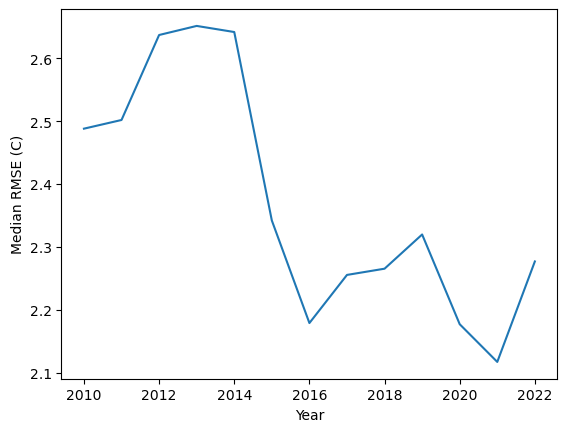

In [7]:
ax = sns.lineplot(perf_byyr, x=perf_byyr.index, y="RMSE")
ax.set_xlabel("Year")
ax.set_ylabel("Median RMSE (C)")

## Regime Shift/Disturbance

# Small Stream

# True Forecast